# AIN433: Computer Vision Lab - Spring 2025
## **Assignment 2**  
#### Instructor: Nazli Ikizler-Cinbis
#### TA: Sibel Kapan

**Student Name**: Süleyman Yolcu

**Student ID**: 2210765016


# PART 1
---

# 0. Setup & Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from pathlib import Path
import time, copy, math, itertools, gc, os
import torch, torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim import lr_scheduler
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

SEED   = 42
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(SEED);  torch.backends.cudnn.deterministic = True
print('Running on:', DEVICE)


Running on: cuda


# 1. Data Loading & Augmentation

In [3]:
ROOT = Path('/content/drive/MyDrive/Colab Notebooks/food11')
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

train_tf = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

eval_tf = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [4]:
def get_loaders(batch_size: int = 32, num_workers: int = 4, pin=True):
    train_ds = datasets.ImageFolder(ROOT/'train',      transform=train_tf)
    val_ds   = datasets.ImageFolder(ROOT/'validation', transform=eval_tf)
    test_ds  = datasets.ImageFolder(ROOT/'test',       transform=eval_tf)

    return (
        {
            'train': DataLoader(train_ds, batch_size, shuffle=True,
                                num_workers=num_workers, pin_memory=pin),
            'val'  : DataLoader(val_ds,   batch_size, shuffle=False,
                                num_workers=num_workers, pin_memory=pin),
            'test' : DataLoader(test_ds,  batch_size, shuffle=False,
                                num_workers=num_workers, pin_memory=pin),
        },
        train_ds.classes
    )

# 2. Model Definitions  
Here we declare two *distinct* CNN architectures that share low-level
building blocks but diverge in their topologies.

* `PlainCNN5` – a straightforward 5-conv network  
* `ResCNN5`   – identical stem, but last two stages become residual blocks


In [5]:
# ---- shared building blocks --------------------------------------------------
class ConvBNReLU(nn.Sequential):
    def __init__(self, in_c, out_c, pool=False):
        layers = [
            nn.Conv2d(in_c, out_c, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
        ]
        if pool: layers.append(nn.MaxPool2d(2))
        super().__init__(*layers)

class ResidualBlock(nn.Module):
    """2×3×3 conv with identity/1×1 projection skip."""
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = ConvBNReLU(in_c, out_c)
        self.conv2 = ConvBNReLU(out_c, out_c)
        self.proj  = nn.Identity() if in_c==out_c else nn.Conv2d(in_c, out_c, 1, bias=False)
    def forward(self, x): return self.conv2(self.conv1(x)) + self.proj(x)

# ---- model A: plain -----------------------------------------------------------
class PlainCNN5(nn.Module):
    """5 conv blocks → 2 FC layers."""
    def __init__(self, n_classes=11, p_drop=0.3):
        super().__init__()
        self.features = nn.Sequential(
            ConvBNReLU(3,   32, pool=True),   # 224→112
            ConvBNReLU(32,  64, pool=True),   # 112→56
            ConvBNReLU(64, 128, pool=True),   # 56 →28
            ConvBNReLU(128,256, pool=True),   # 28 →14
            ConvBNReLU(256,512, pool=True),   # 14 →7
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512*7*7, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p_drop),
            nn.Linear(256, n_classes),
        )
    def forward(self, x): return self.classifier(self.features(x))

# ---- model B: residual --------------------------------------------------------
class ResCNN5(nn.Module):
    """3 conv blocks + 2 residual blocks → 2 FC layers."""
    def __init__(self, n_classes=11, p_drop=0.3):
        super().__init__()
        self.features = nn.Sequential(
            ConvBNReLU(3,   32, pool=True),   # 224→112
            ConvBNReLU(32,  64, pool=True),   # 112→56
            ConvBNReLU(64, 128, pool=True),   # 56 →28
            ResidualBlock(128, 256),
            nn.MaxPool2d(2),                  # 28→14
            ResidualBlock(256, 512),
            nn.MaxPool2d(2),                  # 14→7
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512*7*7, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p_drop),
            nn.Linear(256, n_classes),
        )
    def forward(self, x): return self.classifier(self.features(x))


In [6]:
def count_params(model):
    """Return #trainable parameters (millions)."""
    return sum(p.numel() for p in model.parameters()) / 1e6


# 3. Training & Evaluation Utilities


In [7]:
def epoch_loop(model, loader, criterion, optimiser=None):
    train = optimiser is not None
    model.train(train)

    total_loss = correct = total = 0
    for x, y in tqdm(loader, leave=False):
        x, y = x.to(DEVICE), y.to(DEVICE)

        if train: optimiser.zero_grad()
        with torch.set_grad_enabled(train):
            logits = model(x)
            loss   = criterion(logits, y)
            if train:
                loss.backward()
                optimiser.step()

        total_loss += loss.item() * x.size(0)
        correct    += (logits.argmax(1) == y).sum().item()
        total      += x.size(0)

    return total_loss/total, correct/total

In [8]:
def fit(model, loaders, *,
        epochs=50, lr=1e-3, scheduler_fn=None,
        tag='?', bs=0, display_every=10):
    print(f"[{tag}] bs={bs} lr={lr:.0e} ")
    criterion  = nn.CrossEntropyLoss()
    optimiser  = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler  = scheduler_fn(optimiser, epochs) if scheduler_fn else None

    history = {'train':[], 'val':[]}
    best    = {'state': None, 'val_acc': 0.0}

    for ep in range(1, epochs + 1):
        tr_loss, tr_acc = epoch_loop(model, loaders['train'], criterion, optimiser)
        v_loss,  v_acc  = epoch_loop(model, loaders['val'],   criterion)

        if scheduler: scheduler.step()
        history['train'].append({'loss':tr_loss, 'acc':tr_acc})
        history['val'  ].append({'loss':v_loss,  'acc':v_acc})

        if v_acc > best['val_acc']:
            best.update(state=copy.deepcopy(model.state_dict()), val_acc=v_acc)

        # ---------- logging ----------
        if ep % display_every == 0 or ep == epochs:
            print(
                  f"| epoch {ep:02}/{epochs}"
                  f" | train {tr_acc:.3%}/{tr_loss:.3f}"
                  f" | val {v_acc:.3%}/{v_loss:.3f}")

    model.load_state_dict(best['state'])
    return history, best['val_acc']

# 4. Hyper-parameter Grid Search (Plain **vs** Residual)


In [9]:
def run_grid(ModelCls, *, tag,
             lrs=(1e-3, 3e-4, 1e-4), bss=(32, 64),
             epochs=50, p_drop=0.0):
    results = []
    for lr, bs in itertools.product(lrs, bss):
        loaders, _ = get_loaders(batch_size=bs)
        model      = ModelCls(p_drop=p_drop).to(DEVICE)
        print(f">> {tag.upper()}  bs={bs} lr={lr:.0e}  "
          f"params={count_params(model):.2f}M")
        sched = lambda opt, e: torch.optim.lr_scheduler.CosineAnnealingLR(opt, e)
        hist, val_acc = fit(model, loaders,
                            epochs=epochs, lr=lr, scheduler_fn=sched,
                            tag=tag, bs=bs)

        results.append({
            'model'   : tag,               # plain / res
            'bs'      : bs,
            'lr'      : lr,
            'val_acc' : val_acc,
            'history' : hist,              # kept in-memory
            'state'   : copy.deepcopy(model.state_dict())
        })

        # tidy-up GPU & RAM between runs
        del model, loaders
        torch.cuda.empty_cache();  gc.collect()

    return results

In [10]:
plain_grid = run_grid(PlainCNN5, tag='plain')
res_grid   = run_grid(ResCNN5,   tag='res')

>> PLAIN  bs=32 lr=1e-03  params=8.00M
[plain] bs=32 lr=1e-03 


| epoch 10/50 | train 30.409%/2.012 | val 26.909%/2.053


| epoch 20/50 | train 47.955%/1.531 | val 41.818%/1.790


| epoch 30/50 | train 63.909%/1.083 | val 53.091%/1.423


| epoch 40/50 | train 78.636%/0.660 | val 62.182%/1.238


| epoch 50/50 | train 83.591%/0.535 | val 61.818%/1.248
>> PLAIN  bs=64 lr=1e-03  params=8.00M
[plain] bs=64 lr=1e-03 


| epoch 10/50 | train 34.045%/1.918 | val 33.091%/1.991


| epoch 20/50 | train 50.409%/1.459 | val 33.091%/2.386


| epoch 30/50 | train 65.955%/1.049 | val 51.636%/1.487


| epoch 40/50 | train 79.227%/0.669 | val 60.000%/1.212


| epoch 50/50 | train 84.682%/0.559 | val 63.273%/1.132
>> PLAIN  bs=32 lr=3e-04  params=8.00M
[plain] bs=32 lr=3e-04 


| epoch 10/50 | train 50.955%/1.453 | val 50.545%/1.621


| epoch 20/50 | train 70.636%/0.878 | val 51.636%/1.425


| epoch 30/50 | train 87.727%/0.431 | val 60.727%/1.201


| epoch 40/50 | train 95.318%/0.230 | val 59.273%/1.299


| epoch 50/50 | train 97.045%/0.181 | val 62.909%/1.236
>> PLAIN  bs=64 lr=3e-04  params=8.00M
[plain] bs=64 lr=3e-04 


| epoch 10/50 | train 51.909%/1.457 | val 34.545%/2.152


| epoch 20/50 | train 71.182%/0.895 | val 56.727%/1.439


| epoch 30/50 | train 86.227%/0.477 | val 58.182%/1.299


| epoch 40/50 | train 95.545%/0.251 | val 62.909%/1.250


| epoch 50/50 | train 96.500%/0.206 | val 62.909%/1.217
>> PLAIN  bs=32 lr=1e-04  params=8.00M
[plain] bs=32 lr=1e-04 


| epoch 10/50 | train 60.409%/1.197 | val 49.818%/1.558


| epoch 20/50 | train 81.500%/0.627 | val 57.091%/1.381


| epoch 30/50 | train 92.500%/0.313 | val 58.182%/1.298


| epoch 40/50 | train 97.545%/0.188 | val 59.273%/1.258


| epoch 50/50 | train 98.136%/0.168 | val 59.636%/1.216
>> PLAIN  bs=64 lr=1e-04  params=8.00M
[plain] bs=64 lr=1e-04 


| epoch 10/50 | train 57.000%/1.331 | val 45.091%/1.735


| epoch 20/50 | train 75.955%/0.808 | val 58.909%/1.339


| epoch 30/50 | train 87.591%/0.517 | val 60.364%/1.198


| epoch 40/50 | train 91.818%/0.382 | val 61.455%/1.198


| epoch 50/50 | train 93.864%/0.337 | val 61.818%/1.198
>> RES  bs=32 lr=1e-03  params=11.11M
[res] bs=32 lr=1e-03 


| epoch 10/50 | train 47.091%/1.552 | val 39.273%/1.913


| epoch 20/50 | train 71.636%/0.843 | val 43.273%/2.096


| epoch 30/50 | train 92.045%/0.251 | val 47.273%/2.646


| epoch 40/50 | train 97.909%/0.076 | val 48.364%/2.987


| epoch 50/50 | train 98.455%/0.059 | val 48.727%/2.978
>> RES  bs=64 lr=1e-03  params=11.11M
[res] bs=64 lr=1e-03 


| epoch 10/50 | train 50.318%/1.489 | val 36.000%/1.906


| epoch 20/50 | train 81.500%/0.555 | val 44.000%/2.426


| epoch 30/50 | train 96.091%/0.128 | val 46.545%/2.660


| epoch 40/50 | train 98.909%/0.038 | val 48.727%/2.746


| epoch 50/50 | train 99.364%/0.027 | val 46.909%/2.782
>> RES  bs=32 lr=3e-04  params=11.11M
[res] bs=32 lr=3e-04 


| epoch 10/50 | train 65.909%/1.018 | val 44.000%/1.832


| epoch 20/50 | train 93.864%/0.215 | val 52.727%/2.499


| epoch 30/50 | train 98.818%/0.050 | val 50.182%/2.296


| epoch 40/50 | train 99.409%/0.023 | val 49.455%/2.497


| epoch 50/50 | train 99.636%/0.019 | val 49.818%/2.513
>> RES  bs=64 lr=3e-04  params=11.11M
[res] bs=64 lr=3e-04 


| epoch 10/50 | train 66.091%/1.033 | val 45.818%/1.840


| epoch 20/50 | train 94.182%/0.212 | val 48.727%/2.153


| epoch 30/50 | train 98.727%/0.051 | val 52.000%/2.272


| epoch 40/50 | train 99.545%/0.022 | val 51.636%/2.278


| epoch 50/50 | train 99.864%/0.014 | val 52.000%/2.278
>> RES  bs=32 lr=1e-04  params=11.11M
[res] bs=32 lr=1e-04 


| epoch 10/50 | train 69.773%/0.924 | val 52.364%/1.499


| epoch 20/50 | train 96.682%/0.154 | val 57.455%/1.544


| epoch 30/50 | train 99.545%/0.038 | val 59.273%/1.505


| epoch 40/50 | train 99.682%/0.022 | val 63.636%/1.502


| epoch 50/50 | train 99.773%/0.017 | val 61.818%/1.464
>> RES  bs=64 lr=1e-04  params=11.11M
[res] bs=64 lr=1e-04 


| epoch 10/50 | train 67.727%/1.008 | val 49.091%/1.504


| epoch 20/50 | train 94.273%/0.273 | val 58.909%/1.351


| epoch 30/50 | train 99.545%/0.066 | val 60.364%/1.362


| epoch 40/50 | train 99.773%/0.029 | val 65.091%/1.325


| epoch 50/50 | train 99.818%/0.028 | val 63.636%/1.327


In [11]:
def print_best_models(plain_grid, res_grid):
    def _test_acc(state, ModelCls, bs):
        loaders, _ = get_loaders(batch_size=bs)
        model = ModelCls().to(DEVICE)
        model.load_state_dict(state); model.eval()
        _, test_acc = epoch_loop(model, loaders['test'], nn.CrossEntropyLoss())
        return test_acc

    best_plain = max(plain_grid, key=lambda r: r['val_acc'])
    best_res   = max(res_grid,   key=lambda r: r['val_acc'])

    best_plain['test_acc'] = _test_acc(best_plain['state'], PlainCNN5, best_plain['bs'])
    best_res  ['test_acc'] = _test_acc(best_res  ['state'], ResCNN5,   best_res  ['bs'])

    for entry in (best_plain, best_res):
        print(f"\n=== BEST {entry['model'].upper()} MODEL ===")
        print(f"val acc : {entry['val_acc']:.3%}")
        print(f"test acc: {entry['test_acc']:.3%}")
        print(f"lr      : {entry['lr']:.0e}")
        print(f"batch   : {entry['bs']}")
        print("="*32)

In [12]:
print_best_models(plain_grid, res_grid)


=== BEST PLAIN MODEL ===
val acc : 64.364%
test acc: 53.091%
lr      : 3e-04
batch   : 32

=== BEST RES MODEL ===
val acc : 65.455%
test acc: 56.000%
lr      : 1e-04
batch   : 64


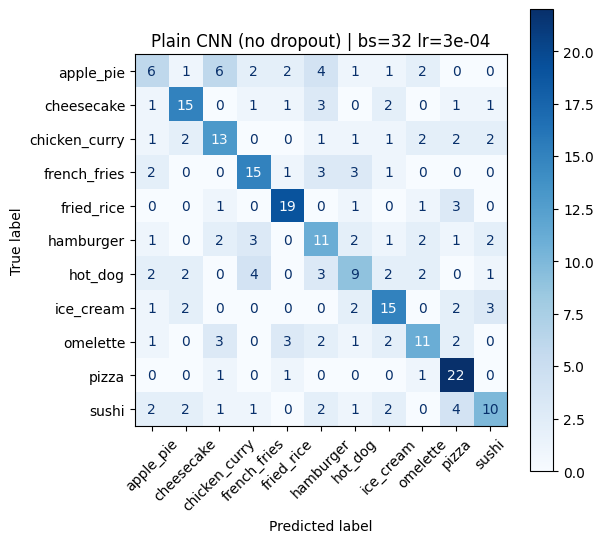

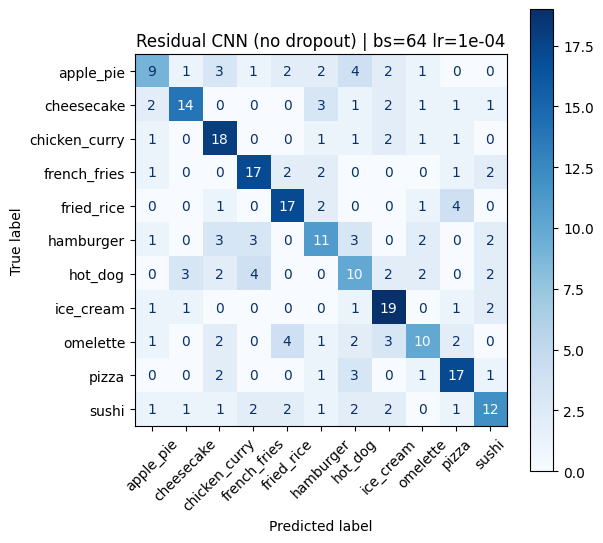

In [23]:
# ---------------------------------------------------------------------------
# Confusion matrices for the best  models
# ---------------------------------------------------------------------------

# pick the highest-validation-accuracy entry from each original grid
best_plain_nd = max(plain_grid, key=lambda d: d['val_acc'])
best_res_nd   = max(res_grid,   key=lambda d: d['val_acc'])

# retrieve the batch size and state_dict that were saved
bs_plain_nd = best_plain_nd['bs']
bs_res_nd   = best_res_nd['bs']

# visualise the confusion matrices
show_confusion(best_plain_nd['state'],
               ModelCls=PlainCNN5,
               bs=bs_plain_nd,
               title=(f"Plain CNN (no dropout) | "
                      f"bs={bs_plain_nd} lr={best_plain_nd['lr']:.0e}"))

show_confusion(best_res_nd['state'],
               ModelCls=ResCNN5,
               bs=bs_res_nd,
               title=(f"Residual CNN (no dropout) | "
                      f"bs={bs_res_nd} lr={best_res_nd['lr']:.0e}"))


# 5. Plotting Helper


In [13]:
def plot_metric_split(result_list, metric, base_title):
    fig_tr,  ax_tr  = plt.subplots(figsize=(7, 5))
    fig_val, ax_val = plt.subplots(figsize=(7, 5))

    for r in result_list:
        epochs = range(1, len(r['history']['train']) + 1)
        label  = f"bs={r['bs']}, lr={r['lr']:.0e}"

        y_tr = [e[metric] for e in r['history']['train']]
        ax_tr.plot(epochs, y_tr, '-',  label=label)

        y_val = [e[metric] for e in r['history']['val']]
        ax_val.plot(epochs, y_val, '-', label=label)

    for ax, phase in ((ax_tr, 'Train'), (ax_val, 'Validation')):
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric.capitalize())
        ax.set_title(f"{base_title} – {phase}")
        ax.grid(alpha=.3)
        ax.legend(ncol=2, fontsize=8)

    return fig_tr, fig_val


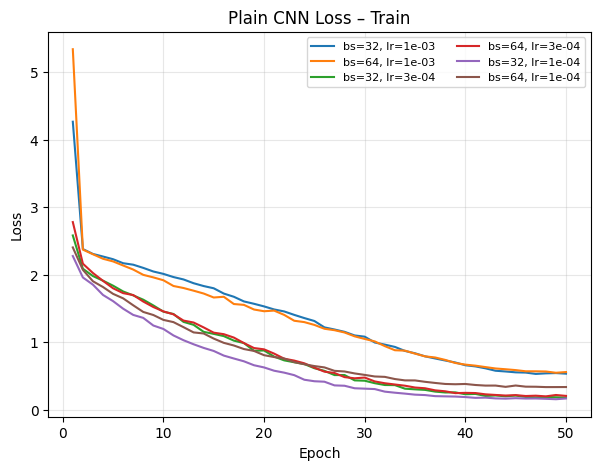

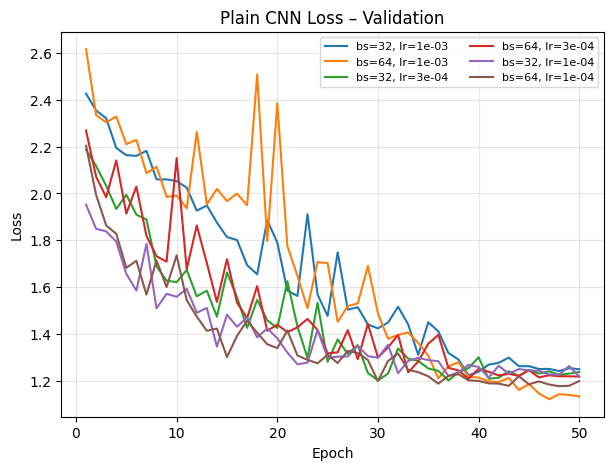

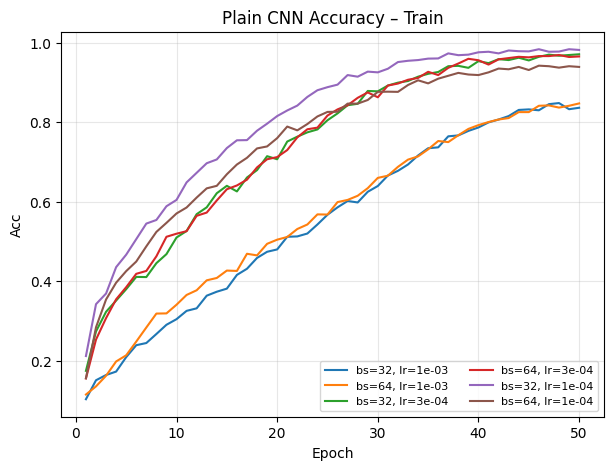

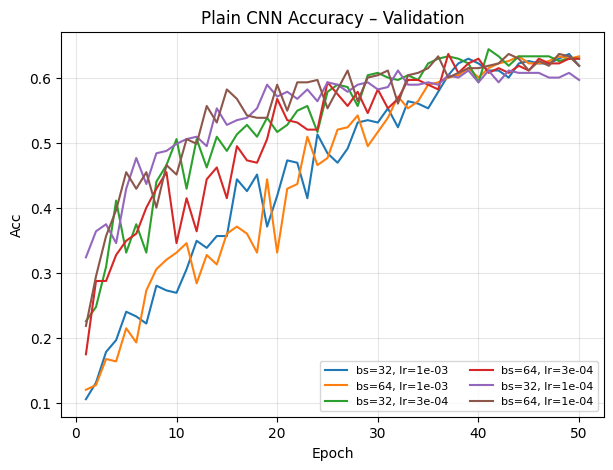

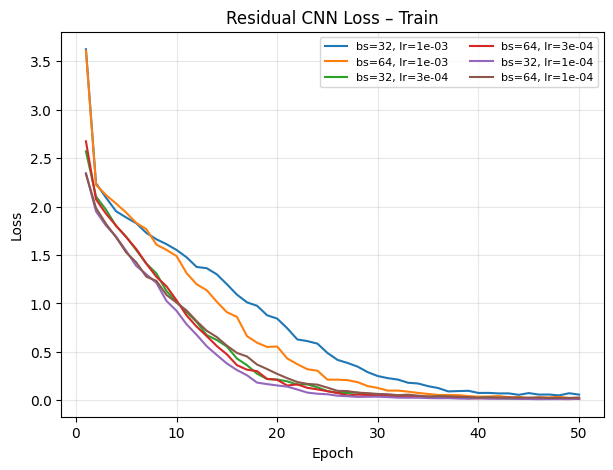

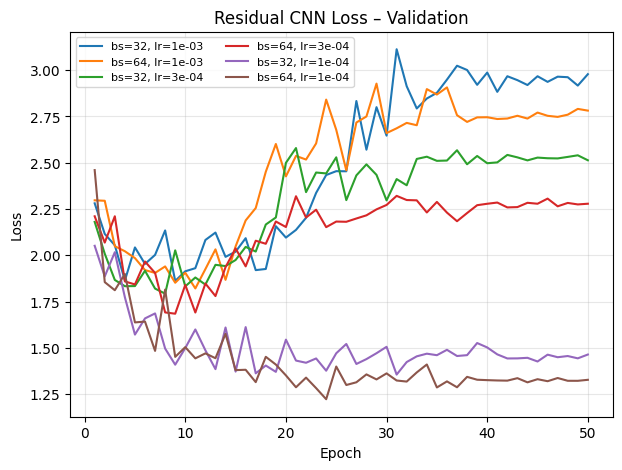

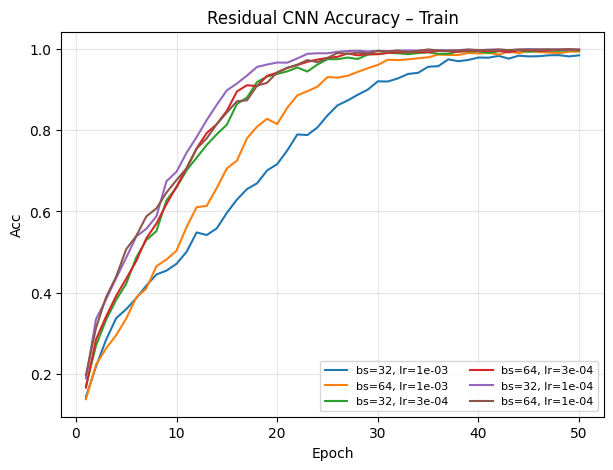

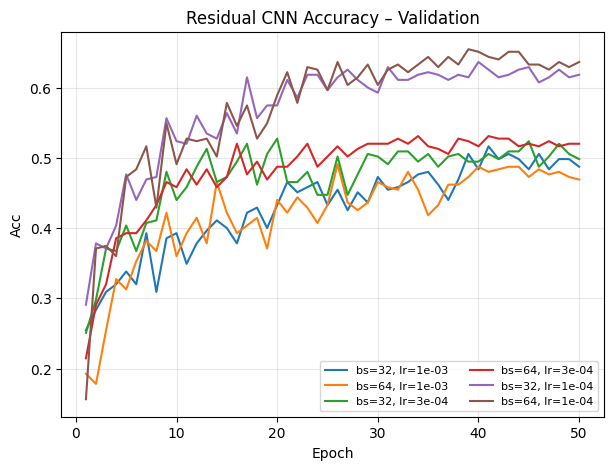

In [14]:

plot_metric_split(plain_grid, 'loss', 'Plain CNN Loss')
plot_metric_split(plain_grid, 'acc',  'Plain CNN Accuracy')


plot_metric_split(res_grid,   'loss', 'Residual CNN Loss')
plot_metric_split(res_grid,   'acc',  'Residual CNN Accuracy')

plt.show()          # show all open figures at once (optional)


# 6. Dropout Re-tuning on the Best Hyper-params


In [15]:
def best_of(grid):
    return max(grid, key=lambda r: r['val_acc'])


def retune_dropout(base_entry, ModelCls, tag,
                   dropouts=(0.2, 0.4), epochs=50):

    loaders, _ = get_loaders(batch_size=base_entry['bs'])
    sched_fn   = lambda opt,e: torch.optim.lr_scheduler.CosineAnnealingLR(opt, e)

    tuned = []
    for p in dropouts:
        model = ModelCls(p_drop=p).to(DEVICE)
        print(f">> {tag.upper()}  dropout={p}  "
          f"params={count_params(model):.2f}M")
        hist, val_acc = fit(model, loaders,
                            epochs=epochs, lr=base_entry['lr'],
                            scheduler_fn=sched_fn,
                            tag=tag, bs=base_entry['bs'])

        _, test_acc = epoch_loop(model, loaders['test'],
                                 nn.CrossEntropyLoss())

        tuned.append({
            'model'   : tag,
            'bs'      : base_entry['bs'],
            'lr'      : base_entry['lr'],
            'p'       : p,
            'val_acc' : val_acc,
            'test_acc': test_acc,
            'history' : hist,
            'state'   : copy.deepcopy(model.state_dict())
        })

        print(f"dropout={p}: val {val_acc:.3%} | test {test_acc:.3%}")

        del model
        torch.cuda.empty_cache(); gc.collect()

    return tuned

In [16]:
plain_dropout = retune_dropout(best_of(plain_grid), PlainCNN5, tag='plain')
res_dropout   = retune_dropout(best_of(res_grid),   ResCNN5, tag='res')

>> PLAIN  dropout=0.2  params=8.00M
[plain] bs=32 lr=3e-04 


| epoch 10/50 | train 39.182%/1.774 | val 39.273%/1.775


| epoch 20/50 | train 53.955%/1.345 | val 50.182%/1.441


| epoch 30/50 | train 66.864%/0.987 | val 59.636%/1.279


| epoch 40/50 | train 74.000%/0.790 | val 65.818%/1.078


| epoch 50/50 | train 75.409%/0.704 | val 63.273%/1.075


dropout=0.2: val 65.818% | test 54.545%
>> PLAIN  dropout=0.4  params=8.00M
[plain] bs=32 lr=3e-04 


| epoch 10/50 | train 28.273%/1.995 | val 36.000%/1.822


| epoch 20/50 | train 37.818%/1.759 | val 47.273%/1.636


| epoch 30/50 | train 44.591%/1.555 | val 49.455%/1.512


| epoch 40/50 | train 48.682%/1.410 | val 57.091%/1.399


| epoch 50/50 | train 50.818%/1.343 | val 58.545%/1.360


dropout=0.4: val 59.636% | test 49.455%
>> RES  dropout=0.2  params=11.11M
[res] bs=64 lr=1e-04 


| epoch 10/50 | train 63.364%/1.114 | val 54.545%/1.401


| epoch 20/50 | train 92.182%/0.286 | val 56.727%/1.376


| epoch 30/50 | train 98.955%/0.074 | val 61.091%/1.390


| epoch 40/50 | train 99.273%/0.039 | val 59.273%/1.380


| epoch 50/50 | train 99.864%/0.029 | val 61.818%/1.352


dropout=0.2: val 62.182% | test 52.364%
>> RES  dropout=0.4  params=11.11M
[res] bs=64 lr=1e-04 


| epoch 10/50 | train 51.727%/1.484 | val 48.000%/1.594


| epoch 20/50 | train 80.091%/0.630 | val 53.455%/1.446


| epoch 30/50 | train 95.909%/0.182 | val 58.545%/1.451


| epoch 40/50 | train 98.273%/0.098 | val 63.636%/1.338


| epoch 50/50 | train 98.409%/0.084 | val 62.545%/1.337


dropout=0.4: val 63.636% | test 52.364%


# 7. Confusion Matrix for the Overall Best Model


In [17]:
def show_confusion(best_state, ModelCls, *,
                   bs=64, title='Confusion'):

    loaders, class_names = get_loaders(batch_size=bs)

    model = ModelCls().to(DEVICE)
    model.load_state_dict(best_state)
    model.eval()

    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in loaders['test']:
            y_true.extend(y.numpy())
            y_pred.extend(model(x.to(DEVICE)).argmax(1)
                          .cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(6, 6))
    ConfusionMatrixDisplay(
        cm, display_labels=class_names
    ).plot(ax=ax, cmap='Blues', xticks_rotation=45)
    ax.set_title(title)
    plt.show()



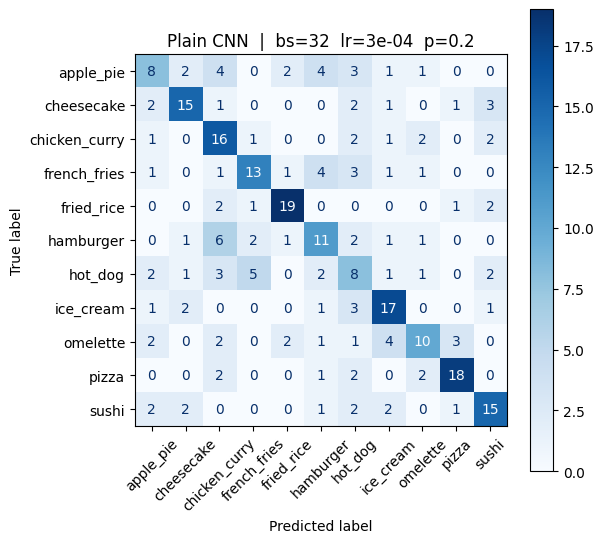

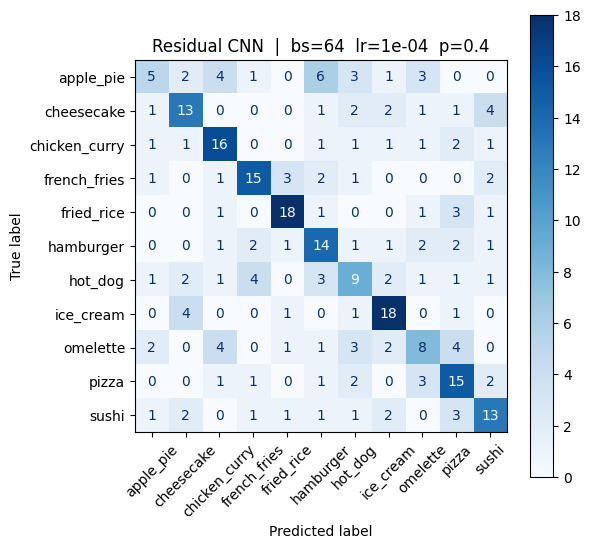

In [18]:
# ---------------------------------------------------------------------------
# Confusion matrices for the best dropout-tuned models (plain & residual)
# ---------------------------------------------------------------------------

# ❶ pick the highest-val-acc run from each family
best_plain = max(plain_dropout, key=lambda d: d['val_acc'])
best_res   = max(res_dropout,   key=lambda d: d['val_acc'])

# ❷ read stored meta-data directly
bs_plain, lr_plain = best_plain['bs'], best_plain['lr']
bs_res,   lr_res   = best_res  ['bs'], best_res  ['lr']

# ❸ visualise
show_confusion(best_plain['state'],
               ModelCls=PlainCNN5,
               bs=bs_plain,
               title=(f"Plain CNN  |  bs={bs_plain}  lr={lr_plain:.0e}  "
                      f"p={best_plain['p']}"))

show_confusion(best_res['state'],
               ModelCls=ResCNN5,
               bs=bs_res,
               title=(f"Residual CNN  |  bs={bs_res}  lr={lr_res:.0e}  "
                      f"p={best_res['p']}"))



=== OVERALL BEST MODEL ===
model   : res
val acc : 65.455%
test acc: 56.000%
bs      : 64
lr      : 1e-04
dropout : no-dropout


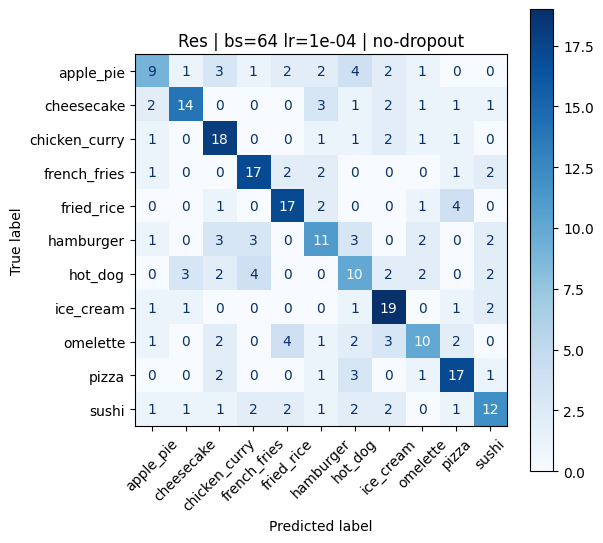

In [19]:
# ---------------------------------------------------------------------------
# Best-of-all selection  (grid + dropout)   +  confusion matrix
# ---------------------------------------------------------------------------

def ensure_test_acc(entry, ModelCls):
    """Add test_acc to entry if absent."""
    if 'test_acc' in entry:
        return
    loaders, _ = get_loaders(batch_size=entry['bs'])
    model = ModelCls().to(DEVICE)
    model.load_state_dict(entry['state'])
    model.eval()
    _, test_acc = epoch_loop(model, loaders['test'], nn.CrossEntropyLoss())
    entry['test_acc'] = test_acc
    del model; torch.cuda.empty_cache(); gc.collect()

def collect_all():
    """Return a single list with unified meta-data from every experiment."""
    all_runs = []

    # ①  original grid results
    for d in plain_grid + res_grid:
        d = d.copy()
        d.setdefault('p', None)        # no dropout
        d.setdefault('model', d['model'])
        d['bs'] = d['bs']
        ensure_test_acc(d, PlainCNN5 if d['model']=='plain' else ResCNN5)
        all_runs.append(d)

    # ②  dropout-tuned results (already have test_acc)
    for d in plain_dropout + res_dropout:
        all_runs.append(d)

    return all_runs

all_runs = collect_all()
best_run = max(all_runs, key=lambda d: d['test_acc'])

# ----- summary print ---------------------------------------------------------
dropout_flag = f"p={best_run['p']}" if best_run['p'] is not None else "no-dropout"
print("\n=== OVERALL BEST MODEL ===")
print(f"model   : {best_run['model']}")
print(f"val acc : {best_run['val_acc']:.3%}")
print(f"test acc: {best_run['test_acc']:.3%}")
print(f"bs      : {best_run['bs']}")
print(f"lr      : {best_run['lr']:.0e}")
print(f"dropout : {dropout_flag}")
print("="*34)

# ----- confusion matrix ------------------------------------------------------
ModelCls = (PlainCNN5 if best_run['model']=='plain'
            else ResCNN5)

show_confusion(best_run['state'],
               ModelCls=ModelCls,
               bs=best_run['bs'],
               title=(f"{best_run['model'].capitalize()} "
                      f"| bs={best_run['bs']} lr={best_run['lr']:.0e} "
                      f"| {dropout_flag}"))


# PART 2
---

In [20]:
from torchvision import models

def mobilenet_v2_ft(num_classes=11):
    """Return a MobileNetV2 with a fresh classifier (fc)."""
    net = models.mobilenet_v2(weights='MobileNet_V2_Weights.IMAGENET1K_V1')
    in_features = net.classifier[-1].in_features          # 1280
    net.classifier[-1] = nn.Linear(in_features, num_classes)
    return net.to(DEVICE)

def freeze_until_last_fc(net):
    """Freeze *everything* except the final Linear layer."""
    for p in net.parameters(): p.requires_grad = False
    for p in net.classifier[-1].parameters(): p.requires_grad = True
    return net

def freeze_until_last2_blocks(net):
    """
    Unfreeze the last *two* inverted-residual blocks + final FC.
    MobileNetV2 features are stored in net.features (18 blocks in PyTorch impl).
    """
    # Get indices of the last two blocks
    trainable_idx = [-1, -2]       # last two blocks
    for idx, block in enumerate(net.features):
        for p in block.parameters():
            p.requires_grad = idx in trainable_idx
    # always train the FC
    for p in net.classifier[-1].parameters(): p.requires_grad = True
    return net


In [21]:
def run_tl_grid(setup_fn, tag,
                lrs=(1e-3, 3e-4, 1e-4), bss=(32, 64),
                epochs=50, wd=1e-4):
    """
    Train MobileNetV2 for every (lr, bs) combination under a freeze policy.

    Returns
    -------
    list of dicts with keys:
        'tag', 'bs', 'lr', 'val_acc', 'test_acc', 'state', 'history'
    """
    results = []
    for lr, bs in itertools.product(lrs, bss):
        loaders, _ = get_loaders(batch_size=bs)

        net = mobilenet_v2_ft().to(DEVICE)   # fresh backbone + new head
        net = setup_fn(net)                  # freeze / unfreeze policy
        print(f">> {tag.upper()}  bs={bs} lr={lr:.0e}  "
          f"trainable={sum(p.requires_grad for p in net.parameters())} / "
          f"{count_params(net):.2f}M total")
        # only params with requires_grad = True get optimised
        optimiser = torch.optim.AdamW(
            filter(lambda p: p.requires_grad, net.parameters()),
            lr=lr, weight_decay=wd
        )
        scheduler = lambda opt,e: torch.optim.lr_scheduler.CosineAnnealingLR(opt, e)

        hist, val_acc = fit(net, loaders,
                            epochs=epochs, lr=lr, scheduler_fn=scheduler,
                            tag=f"{tag}", bs=bs)

        _, test_acc = epoch_loop(net, loaders['test'], nn.CrossEntropyLoss())

        results.append(dict(tag=tag, bs=bs, lr=lr,
                            val_acc=val_acc, test_acc=test_acc,
                            history=hist,
                            state=copy.deepcopy(net.state_dict())))

        del net, loaders
        torch.cuda.empty_cache(); gc.collect()
    return results


# ---- run grids --------------------------------------------------------------
fc_grid   = run_tl_grid(freeze_until_last_fc,        tag='mobilenet_fc')
last2_grid= run_tl_grid(freeze_until_last2_blocks,   tag='mobilenet_last2')

# ---- pick the winners -------------------------------------------------------
best_fc   = max(fc_grid,   key=lambda d: d['val_acc'])
best_last = max(last2_grid,key=lambda d: d['val_acc'])

def _print_entry(e):
    print(f"\n=== {e['tag']} ===")
    print(f"val acc : {e['val_acc']:.3%}")
    print(f"test acc: {e['test_acc']:.3%}")
    print(f"lr      : {e['lr']:.0e}")
    print(f"batch   : {e['bs']}")
    print("="*32)

_print_entry(best_fc)
_print_entry(best_last)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 216MB/s]


>> MOBILENET_FC  bs=32 lr=1e-03  trainable=2 / 2.24M total
[mobilenet_fc] bs=32 lr=1e-03 


| epoch 10/50 | train 82.091%/0.562 | val 88.727%/0.406


| epoch 20/50 | train 85.318%/0.461 | val 87.636%/0.386


| epoch 30/50 | train 86.273%/0.417 | val 87.636%/0.382


| epoch 40/50 | train 87.091%/0.395 | val 89.091%/0.371


| epoch 50/50 | train 87.273%/0.393 | val 89.091%/0.364


>> MOBILENET_FC  bs=64 lr=1e-03  trainable=2 / 2.24M total
[mobilenet_fc] bs=64 lr=1e-03 


| epoch 10/50 | train 83.000%/0.572 | val 85.818%/0.419


| epoch 20/50 | train 86.136%/0.456 | val 86.909%/0.390


| epoch 30/50 | train 86.636%/0.411 | val 88.727%/0.384


| epoch 40/50 | train 88.364%/0.387 | val 88.000%/0.373


| epoch 50/50 | train 87.545%/0.385 | val 88.727%/0.365


>> MOBILENET_FC  bs=32 lr=3e-04  trainable=2 / 2.24M total
[mobilenet_fc] bs=32 lr=3e-04 


| epoch 10/50 | train 79.000%/0.759 | val 87.636%/0.511


| epoch 20/50 | train 82.955%/0.608 | val 88.000%/0.433


| epoch 30/50 | train 83.273%/0.558 | val 88.000%/0.402


| epoch 40/50 | train 82.955%/0.557 | val 88.000%/0.395


| epoch 50/50 | train 83.864%/0.529 | val 89.091%/0.392


>> MOBILENET_FC  bs=64 lr=3e-04  trainable=2 / 2.24M total
[mobilenet_fc] bs=64 lr=3e-04 


| epoch 10/50 | train 77.636%/0.846 | val 86.909%/0.610


| epoch 20/50 | train 81.273%/0.669 | val 88.000%/0.481


| epoch 30/50 | train 83.045%/0.600 | val 88.727%/0.444


| epoch 40/50 | train 83.727%/0.579 | val 88.727%/0.430


| epoch 50/50 | train 84.227%/0.560 | val 88.727%/0.431


>> MOBILENET_FC  bs=32 lr=1e-04  trainable=2 / 2.24M total
[mobilenet_fc] bs=32 lr=1e-04 


| epoch 10/50 | train 73.136%/1.145 | val 84.364%/0.887


| epoch 20/50 | train 77.409%/0.883 | val 85.818%/0.632


| epoch 30/50 | train 79.591%/0.791 | val 86.545%/0.560


| epoch 40/50 | train 79.409%/0.772 | val 86.909%/0.532


| epoch 50/50 | train 79.318%/0.772 | val 86.182%/0.531


>> MOBILENET_FC  bs=64 lr=1e-04  trainable=2 / 2.24M total
[mobilenet_fc] bs=64 lr=1e-04 


| epoch 10/50 | train 71.045%/1.326 | val 85.091%/1.093


| epoch 20/50 | train 76.545%/1.003 | val 86.182%/0.778


| epoch 30/50 | train 77.273%/0.899 | val 87.273%/0.671


| epoch 40/50 | train 78.682%/0.852 | val 87.636%/0.633


| epoch 50/50 | train 79.227%/0.840 | val 88.000%/0.630


>> MOBILENET_LAST2  bs=32 lr=1e-03  trainable=2 / 2.24M total
[mobilenet_last2] bs=32 lr=1e-03 


| epoch 10/50 | train 82.136%/0.555 | val 87.273%/0.405


| epoch 20/50 | train 84.409%/0.472 | val 89.455%/0.369


| epoch 30/50 | train 87.318%/0.424 | val 89.455%/0.370


| epoch 40/50 | train 86.909%/0.401 | val 89.455%/0.360


| epoch 50/50 | train 88.273%/0.385 | val 89.091%/0.367


>> MOBILENET_LAST2  bs=64 lr=1e-03  trainable=2 / 2.24M total
[mobilenet_last2] bs=64 lr=1e-03 


| epoch 10/50 | train 82.455%/0.574 | val 86.909%/0.429


| epoch 20/50 | train 85.227%/0.462 | val 87.273%/0.397


| epoch 30/50 | train 87.091%/0.414 | val 89.455%/0.378


| epoch 40/50 | train 88.091%/0.393 | val 88.727%/0.369


| epoch 50/50 | train 88.909%/0.377 | val 89.091%/0.370


>> MOBILENET_LAST2  bs=32 lr=3e-04  trainable=2 / 2.24M total
[mobilenet_last2] bs=32 lr=3e-04 


| epoch 10/50 | train 78.636%/0.773 | val 86.545%/0.530


| epoch 20/50 | train 81.545%/0.627 | val 87.273%/0.431


| epoch 30/50 | train 83.000%/0.562 | val 87.273%/0.402


| epoch 40/50 | train 85.091%/0.519 | val 87.636%/0.393


| epoch 50/50 | train 84.500%/0.533 | val 88.000%/0.390


>> MOBILENET_LAST2  bs=64 lr=3e-04  trainable=2 / 2.24M total
[mobilenet_last2] bs=64 lr=3e-04 


| epoch 10/50 | train 77.818%/0.841 | val 86.182%/0.609


| epoch 20/50 | train 82.136%/0.667 | val 88.727%/0.476


| epoch 30/50 | train 84.636%/0.577 | val 88.727%/0.437


| epoch 40/50 | train 83.000%/0.580 | val 89.091%/0.425


| epoch 50/50 | train 83.727%/0.567 | val 89.091%/0.422


>> MOBILENET_LAST2  bs=32 lr=1e-04  trainable=2 / 2.24M total
[mobilenet_last2] bs=32 lr=1e-04 


| epoch 10/50 | train 73.045%/1.152 | val 85.455%/0.886


| epoch 20/50 | train 77.455%/0.881 | val 86.182%/0.633


| epoch 30/50 | train 79.364%/0.797 | val 86.545%/0.563


| epoch 40/50 | train 80.000%/0.756 | val 87.273%/0.538


| epoch 50/50 | train 80.182%/0.759 | val 86.545%/0.534


>> MOBILENET_LAST2  bs=64 lr=1e-04  trainable=2 / 2.24M total
[mobilenet_last2] bs=64 lr=1e-04 


| epoch 10/50 | train 72.091%/1.345 | val 83.273%/1.129


| epoch 20/50 | train 77.227%/1.016 | val 84.000%/0.799


| epoch 30/50 | train 78.227%/0.896 | val 86.182%/0.686


| epoch 40/50 | train 78.136%/0.866 | val 85.818%/0.658


| epoch 50/50 | train 78.682%/0.851 | val 87.273%/0.646



=== mobilenet_fc ===
val acc : 89.818%
test acc: 79.636%
lr      : 1e-03
batch   : 32

=== mobilenet_last2 ===
val acc : 90.545%
test acc: 80.364%
lr      : 1e-03
batch   : 64


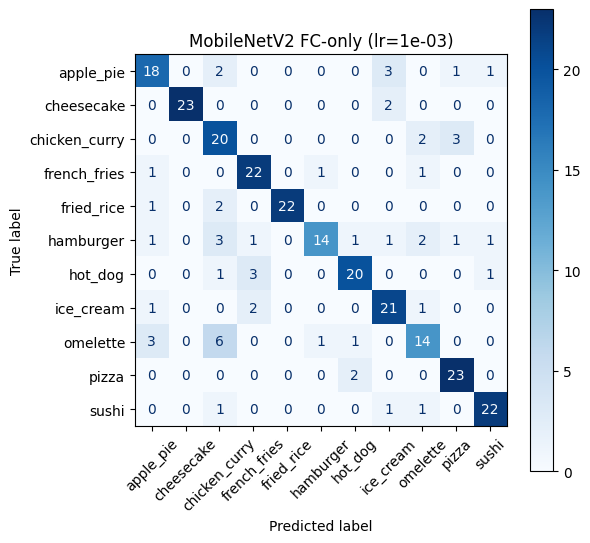

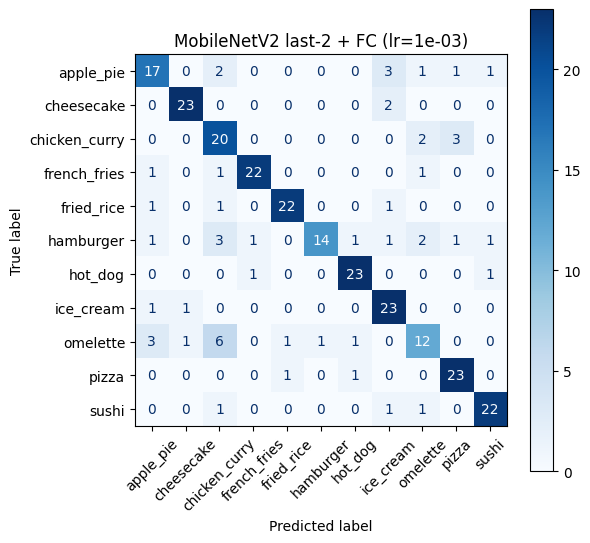

In [22]:
show_confusion(best_fc['state'],
               ModelCls=mobilenet_v2_ft,
               bs=best_fc['bs'],
               title=f"MobileNetV2 FC-only (lr={best_fc['lr']:.0e})")

show_confusion(best_last['state'],
               ModelCls=mobilenet_v2_ft,
               bs=best_last['bs'],
               title=f"MobileNetV2 last-2 + FC (lr={best_last['lr']:.0e})")
